In [ ]:
"""

Date: November 23, 2022

Author: Karine Choquet

This script will perform analyses and generate datasets for Figures 4 and S5-6 of the splicing order manuscript


"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

from tqdm import tqdm

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

import random
from numpy.random import choice

import itertools

import upsetplot
from upsetplot import plot
from upsetplot import generate_counts

In [2]:
# Use GENCODE annotations
gene_names_df = pd.read_table("/path/to/Ensembl_geneID2name_hsapiens_gene_ensembl.txt")

# Add the number of introns per gene
gencode_introns_df = pd.read_table("/path/to/gene_annotations/GENCODE_V38_introns.bed", header=None)
gencode_introns_df.columns = ['chrom','start','end','intron_name','score','strand']
gencode_introns_df['chrom'] = gencode_introns_df['chrom'].str[3:]
gencode_introns_df['gene'] = gencode_introns_df['intron_name'].str.split("_").str[0]
gencode_n_introns = pd.DataFrame(gencode_introns_df.groupby(['gene','strand'])['intron_name'].count()).reset_index().rename(columns={'intron_name':'intron_total'})

# Compute the real intron position
gencode_introns_df_tmp = gencode_introns_df.merge(gencode_n_introns, on=['gene','strand'])
gencode_introns_df_tmp['intron_count'] = gencode_introns_df_tmp['intron_name'].str.split("_").str[2].astype(int)
gencode_introns_df_minus = gencode_introns_df_tmp[gencode_introns_df_tmp['strand']=='-'].reset_index(drop=True)
gencode_introns_df_minus['intron_pos'] = gencode_introns_df_minus['intron_total'] - gencode_introns_df_minus['intron_count']
gencode_introns_df_plus = gencode_introns_df_tmp[gencode_introns_df_tmp['strand']=='+'].reset_index(drop=True)
gencode_introns_df_plus['intron_pos'] = gencode_introns_df_plus['intron_count']+1

gencode_introns_df = pd.concat([gencode_introns_df_minus,gencode_introns_df_plus]).sort_values(by=['chrom','start','end']).reset_index(drop=True).drop(columns=['intron_count'])

## Splicing order for alternative cassette exons

In [3]:
# Load list of SE introns computed from short-read RNA-seq
SE_introns = pd.read_table("/path/to/MN_SE_introns_numbers_Day9_vs_D14_polyA.bed")
gene_names_df = pd.read_table("/path/to/Ensembl_geneID2name_hsapiens_gene_ensembl_with_intron_number_per_gene.txt")

SE_introns = SE_introns.merge(gene_names_df, on=['gene'])

# Introns flanking SE in inclusion isoforms
SE_introns_short = SE_introns[SE_introns['position'].str.contains("short")].reset_index(drop=True)
SE_introns_short_piv = SE_introns_short.pivot_table(index=['event_name','gene','external_gene_name'],columns='position', values='intron_pos').reset_index()
SE_introns_short_piv['AS_introns'] = SE_introns_short_piv['short_intron1'].astype(str) + '_' + SE_introns_short_piv['short_intron2'].astype(str)
SE_introns_short_piv['isoform'] = 'inclusion'

# Introns overlapping with SE in exclusion isoforms
SE_introns_long = SE_introns[SE_introns['position'].str.contains("long")].reset_index(drop=True)
SE_introns_long_piv = SE_introns_long.pivot_table(index=['event_name','gene','external_gene_name'],columns='position', values='intron_pos').reset_index()
SE_introns_long_piv['AS_introns'] = SE_introns_long_piv['long_intron'].astype(str)
SE_introns_long_piv['isoform'] = 'exclusion'

fields = ['event_name','gene','external_gene_name','AS_introns','isoform']

SE_introns_bis = pd.concat([SE_introns_short_piv[fields],SE_introns_long_piv[fields]]).sort_values(by='event_name').reset_index(drop=True)



In [4]:
# Remove duplicate intron groups (same coordinates but different transcript)
def remove_duplicate_introns(path_df_tmp):
    
    path_df = path_df_tmp[['gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    # Remove duplicates intron groups because they belong to different transcripts
    intron_groups = path_df[['gene','gene_name','analyzed_introns','n_analyzed_introns']].drop_duplicates().reset_index(drop=True)

    intron_groups_2 = intron_groups[intron_groups['n_analyzed_introns']==2].reset_index(drop=True)
    intron_groups_2['int1'] = intron_groups_2['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_2['int2'] = intron_groups_2['analyzed_introns'].str.split("_").str[1].astype(int)

    intron_groups_2 = intron_groups_2.merge(gencode_introns_df, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_2 = intron_groups_2.merge(gencode_introns_df, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})

    intron_groups_2 = intron_groups_2.sort_values(by=['gene','int1','int2']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2']).reset_index(drop=True)
    
    intron_groups_3 = intron_groups[intron_groups['n_analyzed_introns']==3].reset_index(drop=True)
    intron_groups_3['int1'] = intron_groups_3['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_3['int2'] = intron_groups_3['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_3['int3'] = intron_groups_3['analyzed_introns'].str.split("_").str[2].astype(int)

    intron_groups_3 = intron_groups_3.merge(gencode_introns_df, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_3 = intron_groups_3.merge(gencode_introns_df, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_3 = intron_groups_3.merge(gencode_introns_df, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

    intron_groups_3 = intron_groups_3.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)
    
    
    intron_groups_4 = intron_groups[intron_groups['n_analyzed_introns']==4].reset_index(drop=True)
    intron_groups_4['int1'] = intron_groups_4['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_4['int2'] = intron_groups_4['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_4['int3'] = intron_groups_4['analyzed_introns'].str.split("_").str[2].astype(int)
    intron_groups_4['int4'] = intron_groups_4['analyzed_introns'].str.split("_").str[3].astype(int)

    intron_groups_4 = intron_groups_4.merge(gencode_introns_df, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_4 = intron_groups_4.merge(gencode_introns_df, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_4 = intron_groups_4.merge(gencode_introns_df, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})
    intron_groups_4 = intron_groups_4.merge(gencode_introns_df, left_on=['gene','int4'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_4', 'start':'start_4', 'end':'end_4'})

    intron_groups_4 = intron_groups_4.sort_values(by=['gene','int1','int2','int3','int4']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3','chrom_4','start_4','end_4']).reset_index(drop=True)
    
    intron_groups_5 = intron_groups[intron_groups['n_analyzed_introns']==5].reset_index(drop=True)
    intron_groups_5['int1'] = intron_groups_5['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_5['int2'] = intron_groups_5['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_5['int3'] = intron_groups_5['analyzed_introns'].str.split("_").str[2].astype(int)
    intron_groups_5['int4'] = intron_groups_5['analyzed_introns'].str.split("_").str[3].astype(int)
    intron_groups_5['int5'] = intron_groups_5['analyzed_introns'].str.split("_").str[4].astype(int)

    intron_groups_5 = intron_groups_5.merge(gencode_introns_df, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_5 = intron_groups_5.merge(gencode_introns_df, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_5 = intron_groups_5.merge(gencode_introns_df, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})
    intron_groups_5 = intron_groups_5.merge(gencode_introns_df, left_on=['gene','int4'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_4', 'start':'start_4', 'end':'end_4'})
    intron_groups_5 = intron_groups_5.merge(gencode_introns_df, left_on=['gene','int5'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_5', 'start':'start_5', 'end':'end_5'})

    intron_groups_5 = intron_groups_5.sort_values(by=['gene','int1','int2','int3','int4','int5']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3','chrom_4','start_4','end_4','chrom_5','start_5','end_5']).reset_index(drop=True)
    
    fields = ['gene','gene_name','analyzed_introns','n_analyzed_introns']
    intron_groups_nodup = pd.concat([intron_groups_2[fields],intron_groups_3[fields],intron_groups_4[fields],intron_groups_5[fields]]).sort_values(by=['gene_name','analyzed_introns']).reset_index(drop=True)

    # Merge back with paths
    path_df_tmp_nodup = path_df_tmp.merge(intron_groups_nodup, on=['gene','gene_name','analyzed_introns','n_analyzed_introns'])
    path_df_nodup = path_df_tmp_nodup[['gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    return(path_df_nodup)


# Function to check if the AS introns of interest are in the intron group
def check_AS_introns(full_path, AS_introns):
    path_split = full_path.split("->")
    AS_introns_list = AS_introns.split("_")
    
    if len(AS_introns_list) == 2:
        if AS_introns_list[0] in path_split and AS_introns_list[1] in path_split:
            flag = "YES"
        else:
            flag = "NO"
            
    elif len(AS_introns_list) == 1:
        if AS_introns_list[0] in path_split:
            flag = "YES"
        else:
            flag = "NO"
            
    return(flag)



In [6]:
# Get PSI values for the alternative exons
SE_PSI_df_tmp = pd.read_table("/path/to/MN_SE_inclusion_levels_Day9_vs_D14_polyA.bed")
SE_PSI_df_tmp['D9'] = SE_PSI_df_tmp[['D9_rep1','D9_rep2']].mean(axis=1)
SE_PSI_df_tmp['D14'] = SE_PSI_df_tmp[['D14_rep1','D14_rep2']].mean(axis=1)


In [7]:
# Exclude isoforms that have too low or high PSI
iso_list = []

for i in range(len(SE_PSI_df_tmp)):
    event_name = SE_PSI_df_tmp.loc[i]['event_name']
    D9_PSI = SE_PSI_df_tmp.loc[i]['D9']
    D14_PSI = SE_PSI_df_tmp.loc[i]['D14']
    
    if D9_PSI > 0.1:
        iso_list.append([event_name,'D9','inclusion'])
    if D9_PSI < 0.9:
        iso_list.append([event_name,'D9','exclusion'])
    if D14_PSI > 0.1:
        iso_list.append([event_name,'D14','inclusion'])
    if D14_PSI < 0.9:
        iso_list.append([event_name,'D14','exclusion'])
        
iso_df = pd.DataFrame(iso_list).drop_duplicates().reset_index(drop=True)
iso_df.columns = ['event_name','sample_name','isoform']

In [9]:
# Load splicing orders computed on cluster
D9_SE_paths_tmp = pd.read_table("/path/to/MN_D9_chrRNA_merged_chromatin_splicing_paths_SE_introns.reps_merged.no_unspliced_filter.txt")
D14_SE_paths_tmp = pd.read_table("/path/to/MN_D14_chrRNA_merged_chromatin_splicing_paths_SE_introns.reps_merged.no_unspliced_filter.txt")

# Remove duplicate intron groups
D9_SE_paths = remove_duplicate_introns(D9_SE_paths_tmp)
D14_SE_paths = remove_duplicate_introns(D14_SE_paths_tmp)

D9_SE_paths['sample_name'] = 'D9'
D14_SE_paths['sample_name'] = 'D14'

MN_SE_paths = pd.concat([D9_SE_paths,D14_SE_paths]).reset_index(drop=True)

# Merge splicing orders with SE introns and check whether the SE introns are present in the intron groups
MN_paths = MN_SE_paths.merge(SE_introns_bis, on=['gene'])
MN_paths['good_AS'] = MN_paths.apply(lambda row: check_AS_introns(row.full_path, row.AS_introns),axis=1)
MN_paths = MN_paths[MN_paths['good_AS']=="YES"].reset_index(drop=True)
# Merge with isoform category (exclusion/inclusion) and event name
MN_paths = MN_paths.merge(iso_df, on=['event_name','isoform','sample_name'])

# Filter for the number of introns: exclusion isoforms should have at least 2, inclusion isoforms should have at least 3
MN_paths = MN_paths[((MN_paths['isoform']=='inclusion') & (MN_paths['n_analyzed_introns']>=3)) |
                   ((MN_paths['isoform']=='exclusion') & (MN_paths['n_analyzed_introns']>=2))].reset_index(drop=True)



In [10]:
# Function to obtain a generic path based on when the AS introns are removed
def get_generic_AS_path(full_path, AS_introns):
    
    path_split = full_path.split("->")
    
    AS_introns_list = AS_introns.split("_")

    new_path_list = []
    for k in path_split:
        if k not in AS_introns_list:
            new_path_list.append("other")
        elif k in AS_introns_list:
            new_path_list.append("AS_intron")
            
    if len(AS_introns_list) == 2:            
        if new_path_list[-1] == "AS_intron" and new_path_list[-2] == "AS_intron":
            AS_status = "AS_last"
        elif (new_path_list[-1] == "AS_intron" and new_path_list[-2] != "AS_intron"):
            AS_status = "AS_last_single"
        elif new_path_list[0] == "AS_intron" and new_path_list[1] == "AS_intron":
            AS_status = "AS_first"
        elif (new_path_list[0] == "AS_intron" and new_path_list[1] != "AS_intron"):
            AS_status = "other"
        else:
            AS_status = "other"
            
    elif len(AS_introns_list) == 1:
        if new_path_list[0] == "AS_intron":
            AS_status = "AS_first"
        elif new_path_list[-1] == "AS_intron":
            AS_status = "AS_last"
        else:
            AS_status = "other"
            
    else:
        AS_status = "other"
            
    return(AS_status)
    

In [11]:
# Get intron groups that have both inclusion and exclusion isoforms in each sample
MN_paths_D9_incl = MN_paths[(MN_paths['sample_name']=='D9') & (MN_paths['isoform']=='inclusion')][['event_name','AS_introns']].drop_duplicates().reset_index(drop=True)
MN_paths_D9_excl = MN_paths[(MN_paths['sample_name']=='D9') & (MN_paths['isoform']=='exclusion')][['event_name','AS_introns']].drop_duplicates().reset_index(drop=True)
MN_paths_D14_incl = MN_paths[(MN_paths['sample_name']=='D14') & (MN_paths['isoform']=='inclusion')][['event_name','AS_introns']].drop_duplicates().reset_index(drop=True)
MN_paths_D14_excl = MN_paths[(MN_paths['sample_name']=='D14') & (MN_paths['isoform']=='exclusion')][['event_name','AS_introns']].drop_duplicates().reset_index(drop=True)

# Merge all isoforms and timepoints
MN_paths_wide = MN_paths_D9_incl.merge(MN_paths_D9_excl, on='event_name', how='outer').merge(MN_paths_D14_incl, on='event_name', how='outer').merge(MN_paths_D14_excl, on='event_name', how='outer').fillna("none")
MN_paths_wide.columns = ['event_name','D9_incl','D9_excl','D14_incl','D14_excl']

# Filter for intron groups where both the inclusion and exclusion isoforms are observed,
# either at the same timepoint or at different timepoints
MN_paths_filt = MN_paths_wide[((MN_paths_wide['D9_incl']!='none') & (MN_paths_wide['D14_excl']!='none')) |
                             ((MN_paths_wide['D9_excl']!='none') & (MN_paths_wide['D14_incl']!='none')) |
                             ((MN_paths_wide['D9_excl']!='none') & (MN_paths_wide['D9_incl']!='none')) |
                             ((MN_paths_wide['D14_excl']!='none') & (MN_paths_wide['D14_incl']!='none'))].reset_index(drop=True)

# Get a list of final SE event names
MN_paths_filt_list = MN_paths_filt['event_name'].drop_duplicates().tolist()

In [12]:
# Check if the intron groups that are being compared for the inclusion and exclusion isoforms are the same, and remove
# duplicate groups (some remain despite the function used above, if one intron group has the same coordinates as a
# larger intron group, but is within a different transcript)

# initiate new lists
good_regions_incl = []
good_regions_excl = []

for event_name in MN_paths_filt_list:
    
    # Initiate dictionary
    tmp_dict = {}
    my_dict = {'inclusion':{}, 'exclusion':{}}
    
    # Retrieve splicing orders that include that SE event
    df = MN_paths[MN_paths['event_name']==event_name].reset_index(drop=True)
    
    # Define intron groups
    regions = df[['gene','analyzed_introns','isoform','n_analyzed_introns']].drop_duplicates().sort_values(by='n_analyzed_introns',ascending=False).reset_index(drop=True)
    
    # Count the number of inclusion and exclusion isoforms
    iso_counts = Counter(regions['isoform'].tolist())
    
    # make sure both isoforms are present
    if iso_counts['exclusion'] > 0 and iso_counts['inclusion'] > 0:
        
        # retrieve intron coordinates for each intron group
        for i in range(len(regions)):
            gene = regions.loc[i]['gene']
            analyzed_introns = [int(a) for a in regions.loc[i]['analyzed_introns'].split("_")]
            my_id = gene + ',' + "_".join([str(a) for a in analyzed_introns])
            isoform = regions.loc[i]['isoform']
            
            coord = []
            
            # retrieve coordinates of each intron within the group
            for intron in analyzed_introns:
                start = int(gencode_introns_df[(gencode_introns_df['gene']==gene) & (gencode_introns_df['intron_pos']==intron)]['start'])
                end = int(gencode_introns_df[(gencode_introns_df['gene']==gene) & (gencode_introns_df['intron_pos']==intron)]['end'])
                
                coord.append([start,end])
            
            # Only include intron groups that have not previously been added
            if isoform not in tmp_dict.keys():
                tmp_dict[isoform] = [coord]
                my_dict[isoform][my_id] = coord
            elif isoform in tmp_dict.keys():
                for N in range(len(tmp_dict[isoform])):
                    prev_coord = tmp_dict[isoform][N]
                    if len(coord) == len(prev_coord):
                        if coord == prev_coord:
                            pass
                        elif coord != prev_coord:
                            tmp_dict[isoform].append(coord)
                            my_dict[isoform][my_id] = coord
                    if len(coord) < len(prev_coord):
                        diff_introns = [a for a in coord if a not in prev_coord]
                        if len(diff_introns):
                            pass
        
        # make sure that the intron groups correspond to one another, meaning that the upstream and downstream introns
        # are the same if they are present, and that short SE introns have the same start/end as the long SE intron
        flag = "error"
        # determine which ones correspond between inclusion and exclusion isoforms
        for k in my_dict['inclusion']:
            for m in my_dict['exclusion']:
                # first introns should have the same coordinates (if 4 introns in inclusion isoform)
                if my_dict['inclusion'][k][0] == my_dict['exclusion'][m][0]:
                    # last introns should have the same coordinates (if 4 introns in inclusion isoform)
                    if my_dict['inclusion'][k][-1] == my_dict['exclusion'][m][-1]:
                        # 2nd intron of inclusion isoform should have the same start as middle intron of exclusion isoform
                        if my_dict['inclusion'][k][1][0] == my_dict['exclusion'][m][1][0]:
                            # 3rd intron of inclusion isoform should have the same end as middle intron of exclusion isoform
                            if my_dict['inclusion'][k][2][1] == my_dict['exclusion'][m][1][1]:
                                good_regions_incl.append(k)
                                good_regions_excl.append(m)
                                flag = "good"
                    # if last introns don't have same coordinates:
                    elif my_dict['inclusion'][k][-1] != my_dict['exclusion'][m][-1]:
                        # 2nd intron of inclusion isoform should have the same start as middle intron of exclusion isoform
                        if my_dict['inclusion'][k][1][0] == my_dict['exclusion'][m][1][0]:
                            # 3rd intron of inclusion isoform should have the same end as middle intron of exclusion isoform
                            if my_dict['inclusion'][k][2][1] == my_dict['exclusion'][m][1][1]:
                                good_regions_incl.append(k)
                                good_regions_excl.append(m)
                                flag = "good"
                # if first introns don't have same coordinates:
                elif my_dict['inclusion'][k][0] != my_dict['exclusion'][m][0]:
                    # last introns should have the same coordinates
                    if my_dict['inclusion'][k][-1] == my_dict['exclusion'][m][-1]:
                        # 3rd last intron of inclusion isoform should have the same start as 2nd last intron of exclusion isoform
                        if my_dict['inclusion'][k][-3][0] == my_dict['exclusion'][m][-2][0]:
                            # 2nd last intron of inclusion isoform should have the same end as 2nd last intron of exclusion isoform
                            if my_dict['inclusion'][k][-2][1] == my_dict['exclusion'][m][-2][1]:
                                good_regions_incl.append(k)
                                good_regions_excl.append(m)  
                                flag = "good"
        
        if flag == "error":
            print(event_name, my_id, flag)
                        

ENSG00000106462_EZH2_chr7_148818977_148819059_- ENST00000498186.5,9_8 error


In [13]:
# Process groups in a dataframe format
filtered_groups = pd.DataFrame({'exclusion': good_regions_excl, 'inclusion': good_regions_incl}).melt(var_name = 'isoform', value_name='id')
filtered_groups['gene'] = filtered_groups['id'].str.split(",").str[0]
filtered_groups['analyzed_introns'] = filtered_groups['id'].str.split(",").str[1]
filtered_groups = filtered_groups.drop(columns = ['id'])



In [15]:
# Get generic path
MN_paths['generic_path'] = MN_paths.apply(lambda row: get_generic_AS_path(row.full_path, row.AS_introns),axis=1)

# Get only the paths that correspond to comparable regions between exclusion and inclusion as determined above
MN_paths_sub = MN_paths[MN_paths['event_name'].isin(MN_paths_filt_list)].merge(filtered_groups, on=['isoform','gene','analyzed_introns']).drop_duplicates().reset_index(drop=True)

# Sum up scores per generic path
MN_paths_grp = pd.DataFrame(MN_paths_sub.groupby(['gene','gene_name','analyzed_introns','sample_name','event_name','isoform','generic_path'])['full_path_score'].sum()).sort_values(by='event_name').reset_index()
MN_paths_grp2 = pd.DataFrame(MN_paths_grp.groupby(['gene','gene_name','sample_name','event_name','isoform','generic_path'])['full_path_score'].mean()).sort_values(by='event_name').reset_index()
MN_paths_grp2['order'] = MN_paths_grp2['sample_name'] + ',' + MN_paths_grp2['isoform'] + ',' + MN_paths_grp2['generic_path']

# Filter for isoforms that have dPSI > 0.1 between two timepoints
MN_paths_grp2 = MN_paths_grp2.merge(iso_df, on=['event_name','sample_name','isoform'])

# For SE events that only differ by a few nucleotides, only keep one so that the intron group is not represented twice
dup_events = ['ENSG00000054148_PHPT1_chr9_136850502_136850560_+','ENSG00000080822_CLDND1_chr3_98521652_98521703_-',
             'ENSG00000115875_SRSF7_chr2_38748897_38749173_-','ENSG00000151923_TIAL1_chr10_119580470_119580846_-',
             'ENSG00000156976_EIF4A2_chr3_186788309_186788416_+','ENSG00000087274_ADD1_chr4_2926638_2926675_+']
MN_paths_grp2 = MN_paths_grp2[~MN_paths_grp2['event_name'].isin(dup_events)].reset_index(drop=True)

# Pivot table
MN_paths_grp_piv = MN_paths_grp2.pivot_table(index='event_name', columns='order', values='full_path_score').fillna(-1)



In [67]:
# Write to file for Supplemental Table
MN_paths_grp2.to_csv("/path/to/TableS7_splicing_order_AS_sMN.txt", sep="\t", header=True, index=False)

In [18]:
# Hierarchical clustering based on exon inclusion levels
SE_PSI_df_tmp2 = SE_PSI_df_tmp[SE_PSI_df_tmp['event_name'].isin(MN_paths_grp2['event_name'].tolist())].sort_values(by='event_name').drop_duplicates(subset='event_name').reset_index(drop=True)
SE_PSI_df_tmp2.index = SE_PSI_df_tmp2['event_name']
SE_PSI_df = SE_PSI_df_tmp2.copy()[['D9','D14']]

linkage_paths = scipy.cluster.hierarchy.linkage(SE_PSI_df, method="average")

In [19]:
len(MN_paths_grp_piv)

65

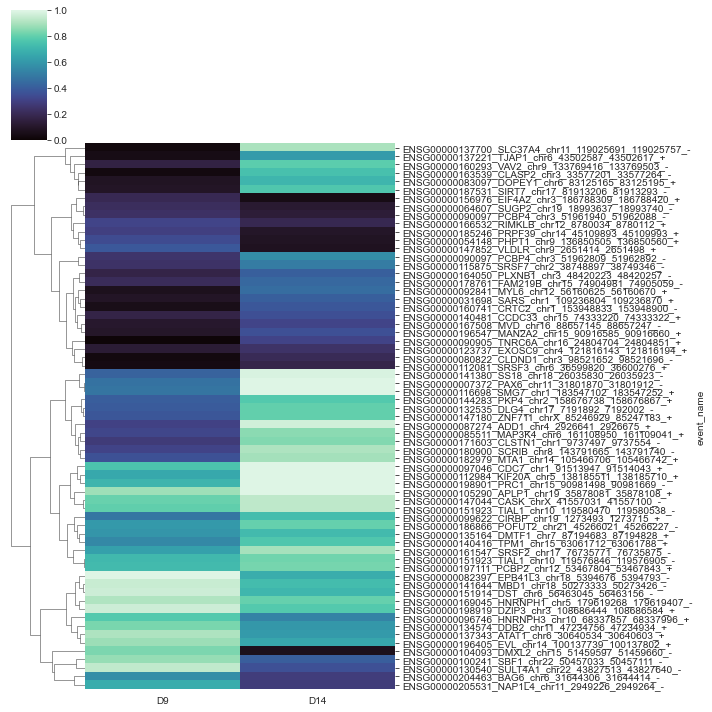

In [20]:
# Plot exon inclusion levels
sns.clustermap(SE_PSI_df, col_cluster=False, row_linkage=linkage_paths, vmin=0, vmax=1, cmap="mako",
              yticklabels=True)

plt.savefig("/path/to/plots/Fig4_splicing_order_isoforms_MN_heatmap_inclusion.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

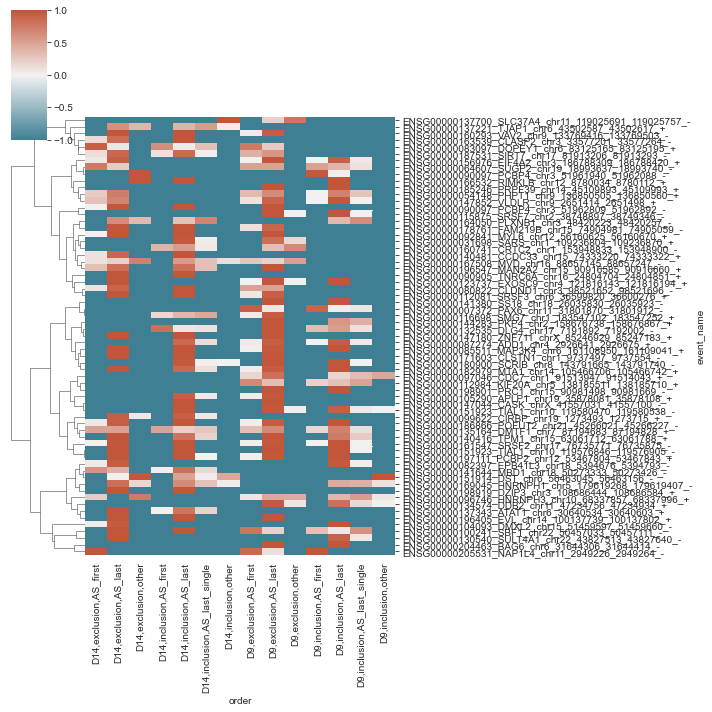

In [21]:
# Plot splicing order scores
sns.clustermap(MN_paths_grp_piv, col_cluster=False, row_linkage=linkage_paths, vmin=-1, vmax=1,
              cmap=sns.diverging_palette(220, 20, as_cmap=True), yticklabels=True)

plt.savefig("/path/to/plots/Fig4_splicing_order_isoforms_MN_heatmap_scores.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [22]:
# Reformat to get a long dataframe
MN_paths_m = MN_paths_grp_piv.reset_index().melt(id_vars='event_name',value_name='score')
MN_paths_m = MN_paths_m[MN_paths_m['score']!=-1].reset_index(drop=True)

In [361]:
# Write to file
MN_paths_m.to_csv("/path/to/MN_D9_vs_D14_splicing_order_AS_generic_paths.txt", sep="\t", header=True, index=False)

In [23]:
# Compare top splicing order for each pair of isoforms/timepoints
# D9 incl vs. excl
MN_paths_top_D9 = MN_paths[(MN_paths['rank']==1) & (MN_paths['event_name'].isin(MN_paths_filt_list)) & (MN_paths['sample_name']=='D9')].reset_index(drop=True)
MN_paths_top_D9_incl = MN_paths_top_D9[(MN_paths_top_D9['isoform']=='inclusion')][['event_name','generic_path',]].drop_duplicates().reset_index(drop=True)
MN_paths_top_D9_excl = MN_paths_top_D9[(MN_paths_top_D9['isoform']=='exclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)

MN_paths_top_D9_both = MN_paths_top_D9_incl.merge(MN_paths_top_D9_excl, on='event_name', how='outer').fillna('none')
MN_paths_top_D9_both = MN_paths_top_D9_both[(MN_paths_top_D9_both['generic_path_x']!='none') & (MN_paths_top_D9_both['generic_path_y']!='none')]
MN_paths_top_D9_counts = pd.DataFrame(MN_paths_top_D9_both.groupby(['generic_path_x','generic_path_y'])['event_name'].count()).reset_index()
MN_paths_top_D9_counts['comparison'] = 'D9_incl_vs_excl'


In [24]:
# D14 incl vs. excl
MN_paths_top_D14 = MN_paths[(MN_paths['rank']==1) & (MN_paths['event_name'].isin(MN_paths_filt_list)) & (MN_paths['sample_name']=='D14')].reset_index(drop=True)
MN_paths_top_D14_incl = MN_paths_top_D14[(MN_paths_top_D14['isoform']=='inclusion')][['event_name','generic_path',]].drop_duplicates().reset_index(drop=True)
MN_paths_top_D14_excl = MN_paths_top_D14[(MN_paths_top_D14['isoform']=='exclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)

MN_paths_top_D14_both = MN_paths_top_D14_incl.merge(MN_paths_top_D14_excl, on='event_name', how='outer').fillna('none')
MN_paths_top_D14_both = MN_paths_top_D14_both[(MN_paths_top_D14_both['generic_path_x']!='none') & (MN_paths_top_D14_both['generic_path_y']!='none')]
MN_paths_top_D14_counts = pd.DataFrame(MN_paths_top_D14_both.groupby(['generic_path_x','generic_path_y'])['event_name'].count()).reset_index()
MN_paths_top_D14_counts['comparison'] = 'D14_incl_vs_excl'


In [25]:
# D9 vs. D14 incl
MN_paths_top_D9 = MN_paths[(MN_paths['rank']==1) & (MN_paths['event_name'].isin(MN_paths_filt_list)) & (MN_paths['sample_name']=='D9')].reset_index(drop=True)
MN_paths_top_D9_incl = MN_paths_top_D9[(MN_paths_top_D9['isoform']=='inclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)
MN_paths_top_D14_incl = MN_paths_top_D14[(MN_paths_top_D14['isoform']=='inclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)

MN_paths_top_incl_both = MN_paths_top_D9_incl.merge(MN_paths_top_D14_incl, on=['event_name'], how='outer').fillna('none')
MN_paths_top_incl_both = MN_paths_top_incl_both[(MN_paths_top_incl_both['generic_path_y']!='none') & ((MN_paths_top_incl_both['generic_path_x']!='none'))]
MN_paths_top_incl_counts = pd.DataFrame(MN_paths_top_incl_both.groupby(['generic_path_x','generic_path_y'])['event_name'].count()).reset_index()
MN_paths_top_incl_counts['comparison'] = 'incl_D9_vs_D14'


In [26]:
# D9 vs. D14 excl
MN_paths_top_D9 = MN_paths[(MN_paths['rank']==1) & (MN_paths['event_name'].isin(MN_paths_filt_list)) & (MN_paths['sample_name']=='D9')].reset_index(drop=True)
MN_paths_top_D9_excl = MN_paths_top_D9[(MN_paths_top_D9['isoform']=='exclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)
MN_paths_top_D14_excl = MN_paths_top_D14[(MN_paths_top_D14['isoform']=='exclusion')][['event_name','generic_path']].drop_duplicates().reset_index(drop=True)

MN_paths_top_excl_both = MN_paths_top_D9_excl.merge(MN_paths_top_D14_excl, on=['event_name'], how='outer').fillna('none')
MN_paths_top_excl_both = MN_paths_top_excl_both[(MN_paths_top_excl_both['generic_path_y']!='none') & ((MN_paths_top_excl_both['generic_path_x']!='none'))]
MN_paths_top_excl_counts = pd.DataFrame(MN_paths_top_excl_both.groupby(['generic_path_x','generic_path_y'])['event_name'].count()).reset_index()
MN_paths_top_excl_counts['comparison'] = 'excl_D9_vs_D14'



In [27]:
# Write to file
pairwise_df = pd.concat([MN_paths_top_excl_counts,MN_paths_top_incl_counts,
                         MN_paths_top_D9_counts,MN_paths_top_D14_counts]).reset_index()
pairwise_df.to_csv("/path/to/MN_splicing_order_AS_pairwise_comparisons_counts.txt",sep="\t", header=True, index=False)


In [28]:
# Calculate evenness

In [29]:
# Function to calculate Shannon diversity index and Evenness
# Formulas taken from here: https://www.tutorialspoint.com/statistics/shannon_wiener_diversity_index.htm
# https://en.wikipedia.org/wiki/Species_evenness

def SDI(path_scores, max_paths):
    
    H = round(-(np.sum(np.log(path_scores) * path_scores)),2) 
    max_H = round(np.log(max_paths),2)
    
    E = round(H/max_H,2)
    
    return(E)

In [36]:
# Calculate Shannon diversity index and Evenness

cand_gene_df = MN_paths_sub[['gene','gene_name','analyzed_introns','sample_name','isoform','event_name']].drop_duplicates().reset_index(drop=True)

SDI_list = []

for i in tqdm(range(len(cand_gene_df))):
    gene = cand_gene_df.loc[i]['gene']
    gene_name = cand_gene_df.loc[i]['gene_name']
    analyzed_introns = cand_gene_df.loc[i]['analyzed_introns']
    sample_name = cand_gene_df.loc[i]['sample_name']
    isoform = cand_gene_df.loc[i]['isoform']
    event_name = cand_gene_df.loc[i]['event_name']
    
    sub_df = MN_paths_sub[(MN_paths_sub['gene']==gene) & (MN_paths_sub['analyzed_introns']==analyzed_introns) &
                       (MN_paths_sub['sample_name']==sample_name) & (MN_paths_sub['isoform']==isoform) &
                         (MN_paths_sub['event_name']==event_name)].drop(columns=['event_name']).drop_duplicates().reset_index(drop=True)
    path_scores = sub_df['full_path_score'].tolist()
    
    n_introns = len(analyzed_introns.split("_"))
    my_SDI = SDI(path_scores, math.factorial(n_introns))
    SDI_list.append([sample_name, gene, gene_name, analyzed_introns, isoform, event_name, my_SDI])
        
SDI_df = pd.DataFrame(SDI_list)
SDI_df.columns = ['sample_name','gene','gene_name','analyzed_introns','isoform','event_name','Evenness']


SDI_df = SDI_df.merge(SE_PSI_df_tmp2['IncLevelDifference'].reset_index(), on='event_name')


100%|██████████| 206/206 [00:00<00:00, 255.59it/s]


In [37]:
SDI_df.to_csv("/path/to/MN_AS_intron_groups_evenness_per_isoform.txt", sep="\t", header=True, index=False)

## MXE events

In [32]:
# Load splicing orders from cluster
D9_MXE_paths_tmp = pd.read_table("/path/to/MN_D9_chrRNA_merged_chromatin_splicing_paths_MXE_introns.reps_merged.no_unspliced_filter.txt")
D14_MXE_paths_tmp = pd.read_table("/path/to/MN_D14_chrRNA_merged_chromatin_splicing_paths_MXE_introns.reps_merged.no_unspliced_filter.txt")

# Remove duplicate intron groups
D9_MXE_paths = remove_duplicate_introns(D9_MXE_paths_tmp)
D14_MXE_paths = remove_duplicate_introns(D14_MXE_paths_tmp)

D9_MXE_paths['sample_name'] = 'D9'
D14_MXE_paths['sample_name'] = 'D14'

MN_MXE_paths = pd.concat([D9_MXE_paths,D14_MXE_paths]).reset_index(drop=True)

In [33]:
# Verify if true MXE: two exons that are mutually exclusive in two isoforms, flanked by common intron(s)

MXE_gene_list = MN_MXE_paths['gene_name'].drop_duplicates().tolist()

# initiate new lists
good_regions = {'iso1': [], 'iso2': []}

for gene_name in MXE_gene_list:
    print(gene_name)

    tmp_dict = {}
    my_dict = {}
    
    df = MN_MXE_paths[MN_MXE_paths['gene_name']==gene_name].reset_index(drop=True)
    
    regions = df[['gene','analyzed_introns','n_analyzed_introns']].drop_duplicates().sort_values(by='n_analyzed_introns',ascending=False).reset_index(drop=True)
    
    iso_counts = Counter(regions['gene'].tolist())
    
    # if more than one isoform are included
    if len(iso_counts) > 1:
        
        # retrieve intron coordinates for each intron group
        for i in range(len(regions)):
            gene = regions.loc[i]['gene']
            analyzed_introns = [int(a) for a in regions.loc[i]['analyzed_introns'].split("_")]
            my_id = gene + ',' + "_".join([str(a) for a in analyzed_introns])
            
            coord = []
            
            for intron in analyzed_introns:
                start = int(gencode_introns_df[(gencode_introns_df['gene']==gene) & (gencode_introns_df['intron_pos']==intron)]['start'])
                end = int(gencode_introns_df[(gencode_introns_df['gene']==gene) & (gencode_introns_df['intron_pos']==intron)]['end'])
                
                coord.append([start,end])
            
            if gene not in tmp_dict.keys():
                tmp_dict[gene] = [coord]
                my_dict[gene] = {}
                my_dict[gene][my_id] = coord

            elif gene in tmp_dict.keys():
                for N in range(len(tmp_dict[gene])):
                    prev_coord = tmp_dict[gene][N]
                    if len(coord) == len(prev_coord):
                        if coord == prev_coord:
                            pass
                        elif coord != prev_coord:
                            tmp_dict[gene].append(coord)
                            my_dict[gene][my_id] = coord
                    if len(coord) < len(prev_coord):
                        diff_introns = [a for a in coord if a not in prev_coord]
                        if len(diff_introns):
                            pass
                        
        flag = "error"
        
        print(my_dict)
        
        # determine which ones correspond between inclusion and exclusion isoforms
        for pair in itertools.combinations(list(my_dict.keys()),2):
            iso1 = pair[0]
            iso2 = pair[1]
        
        for k in my_dict[iso1]:
            for m in my_dict[iso2]:
                # first introns should have the same coordinates (if 4 introns)
                if my_dict[iso1][k][0] == my_dict[iso2][m][0]:
                    # last introns should have the same coordinates (if 4 introns)
                    if my_dict[iso1][k][-1] == my_dict[iso2][m][-1]:
                        # second introns should have same start but different end
                        if (my_dict[iso1][k][1][0] == my_dict[iso2][m][1][0]) and (my_dict[iso1][k][1][1] != my_dict[iso2][m][1][1]):
                            # third introns should have different start but same end
                            if (my_dict[iso1][k][-1][0] != my_dict[iso2][m][-1][0]) and (my_dict[iso1][k][-1][1] == my_dict[iso2][m][-1][1]):
                                good_regions['iso1'].append(k)
                                good_regions['iso2'].append(m)
                                flag = "good"
                    # if last introns don't have same coordinates:
                    elif my_dict[iso1][k][-1] != my_dict[iso2][m][-1]:
                    #    # second introns should have same start but different end
                        if (my_dict[iso1][k][1][0] == my_dict[iso2][m][1][0]) and (my_dict[iso1][k][1][1] != my_dict[iso2][m][1][1]):
                    #        # third introns should have different start but same end
                            if (my_dict[iso1][k][-1][0] != my_dict[iso2][m][-1][0]) and (my_dict[iso1][k][-1][1] == my_dict[iso2][m][-1][1]):
                                good_regions['iso1'].append(k)
                                good_regions['iso2'].append(m)
                                flag = "good"
                # if first introns don't have same coordinates but last introns have same coordinates:
                elif (my_dict[iso1][k][0] != my_dict[iso2][m][0]) and (my_dict[iso1][k][-1] == my_dict[iso2][m][-1]):
                #    # first introns should have same start but different end
                    if (my_dict[iso1][k][0][0] == my_dict[iso2][m][0][0]) and (my_dict[iso1][k][0][1] != my_dict[iso2][m][0][1]):
                        # second introns should have different start but same end
                        if (my_dict[iso1][k][1][0] != my_dict[iso2][m][1][0]) and (my_dict[iso1][k][1][1] == my_dict[iso2][m][1][1]):
                            good_regions['iso1'].append(k)
                            good_regions['iso2'].append(m)
                            flag = "good"
                # if first and last introns don't have same coordinates, so the intron group is only the MXE:
                elif (my_dict[iso1][k][0] != my_dict[iso2][m][0]) and (my_dict[iso1][k][-1] != my_dict[iso2][m][-1]):
                #    # first introns should have same start but different end
                    if (my_dict[iso1][k][0][0] == my_dict[iso2][m][0][0]) and (my_dict[iso1][k][0][1] != my_dict[iso2][m][0][1]):
                        # last introns should have different start but same end
                        if (my_dict[iso1][k][-1][0] != my_dict[iso2][m][-1][0]) and (my_dict[iso1][k][-1][1] == my_dict[iso2][m][-1][1]):
                            good_regions['iso1'].append(k)
                            good_regions['iso2'].append(m)
                            flag = "good"
                

ACTN4
{'ENST00000252699.7': {'ENST00000252699.7,17_18_19': [[38725903, 38726956], [38727103, 38727945], [38728026, 38728995]], 'ENST00000252699.7,18_19_20': [[38727103, 38727945], [38728026, 38728995], [38729154, 38729273]]}, 'ENST00000440400.2': {'ENST00000440400.2,17_18_19': [[38725903, 38726956], [38727103, 38728315], [38728381, 38728995]], 'ENST00000440400.2,18_19_20': [[38727103, 38728315], [38728381, 38728995], [38729154, 38729273]]}}
AKR7A2
BRPF3
CACNB3
CADM1
{'ENST00000536727.5': {'ENST00000536727.5,10_9': [[115176592, 115178643], [115178775, 115190887]], 'ENST00000536727.5,9_8': [[115178775, 115190887], [115190941, 115198405]]}, 'ENST00000542447.6': {'ENST00000542447.6,8_7': [[115176592, 115178643], [115178775, 115214607]]}}
CASK
{'ENST00000378166.9': {'ENST00000378166.9,18_17': [[41553915, 41555599], [41555635, 41559778]]}, 'ENST00000378154.3': {'ENST00000378154.3,19_18': [[41553915, 41557031], [41557100, 41559778]]}}
CCT2
CLSTN1
COPZ1
CPT1C
CRTC2
CYBC1
{'ENST00000434650.6': 

In [34]:
# Process groups in a dataframe format
MXE_filtered_groups = pd.DataFrame({'iso1': good_regions['iso1'], 'iso2': good_regions['iso2']}).melt(var_name='isoform', value_name='id')
MXE_filtered_groups['gene'] = MXE_filtered_groups['id'].str.split(",").str[0]
MXE_filtered_groups['analyzed_introns'] = MXE_filtered_groups['id'].str.split(",").str[1]
MXE_filtered_groups = MXE_filtered_groups.drop(columns = ['id'])

In [35]:
# Retrieve splicing orders for those good intron groups
MN_MXE_paths_sub = MN_MXE_paths.merge(MXE_filtered_groups, on=['gene','analyzed_introns'])

In [ ]:
# Visual inspection of CASK in IGV suggests that it's not a real MXE (many reads contain both exons)
# Splicing orders for the 4 other MXEs were plotted in R